# InSituPy demonstration - Cell type annotation with TACCO

In [1]:
## The following code ensures that all functions and init files are reloaded before executions.
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path
from insitupy import read_xenium
import pandas as pd
import tacco as tc
from insitupy.utils import generate_mock_reference
import scanpy as sc

## Load Xenium data into `InSituData` object

Now the Xenium data can be parsed by providing the data path to the `InSituPy` project folder.

In [5]:
insitupy_project = Path("demo_dataset/demo_insitupy_project/")

In [6]:
xd = read_xenium(insitupy_project)

In [7]:
xd

InSituData
Method:		Xenium
Slide ID:	0001879
Sample ID:	Replicate 1
Path:		C:\Users\ge37voy\Github\InSituPy\notebooks\demo_dataset\demo_insitupy_project
Metadata file:	.ispy

In [8]:
xd.load_images()
xd.load_cells()

Loading images...
Loading cells...
	No alternative cells found...


In [9]:
xd

InSituData
Method:		Xenium
Slide ID:	0001879
Sample ID:	Replicate 1
Path:		C:\Users\ge37voy\Github\InSituPy\notebooks\demo_dataset\demo_insitupy_project
Metadata file:	.ispy
    ➤ images
       nuclei:	(25778, 35416)
       CD20:	(25778, 35416)
       HER2:	(25778, 35416)
       DAPI:	(25778, 35416)
       HE:	(25778, 35416, 3)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 163565 × 313
           obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes', 'leiden'
           var: 'gene_ids', 'feature_types', 'genome'
           uns: 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
           obsm: 'X_pca', 'X_umap', 'annotations', 'spatial'
           varm: 'PCs', 'binned_expression'
           layers: 'counts', 'norm_counts'
           obsp: 'connectivities', 'distances'
       boundaries
           BoundariesData object with 2 entries:
               cellular
               nucle

## TACCO annotation transfer using mock reference

For demonstration purposes here we use the Xenium panel that was used for the breast cancer demo dataset to generate a mock single-cell RNA-seq reference.

In [10]:
# load panel annotated by Jessica Pauli
panel = pd.read_csv("./demo_panel/Xenium_hBreast_v1_metadata.csv")

In [11]:
panel.head()

,Genes,Ensembl_ID,Num_Probesets,Codewords,Annotation
0,ABCC11,ENSG00000121270,7,1,Breast cancer
1,ACTA2,ENSG00000107796,8,1,Smooth muscle cells
2,ACTG2,ENSG00000163017,8,1,Breast myoepithelial cells
3,ADAM9,ENSG00000168615,8,1,Breast glandular cells
4,ADGRE5,ENSG00000123146,8,1,Dendritic cells


In [12]:
panel.Annotation.unique()

array(['Breast cancer', 'Smooth muscle cells',
       'Breast myoepithelial cells', 'Breast glandular cells',
       'Dendritic cells', 'Adipocytes', 'Macrophages',
       'Endothelial cells', 'B cells', 'Epithelial cells', 'Fibroblasts',
       'T cells', 'Monocytes', 'NK cells', 'Neutrophils', 'Mast cells',
       'Myeloid cells', 'Immune cells', 'Plasma cells'], dtype=object)

In [13]:
len(panel.Annotation.unique())

19

Remove ambiguous terms ("Immune cells")

In [14]:
panel = panel[~(panel["Annotation"] == "Immune cells")].copy()

In [15]:
reference = generate_mock_reference(panel, annotation_column="Annotation", gene_column="Genes")

In [16]:
reference

AnnData object with n_obs × n_vars = 18 × 279
    obs: 'Annotation'

In [17]:
xd.cells.matrix

AnnData object with n_obs × n_vars = 163565 × 313
    obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'annotations', 'spatial'
    varm: 'PCs', 'binned_expression'
    layers: 'counts', 'norm_counts'
    obsp: 'connectivities', 'distances'

In [18]:
# set counts location
xd.cells.matrix.uns["counts_location"] = ['layer', 'counts']

In [19]:
# This is the annotation step. OT is our own annotation method, but theres multiple like rctd implemented in Tacco
# Theres also multiple parameters one could adjust, i ran everything with default
tc.tl.annotate(adata=xd.cells.matrix,
               reference=reference,
               annotation_key='Annotation',
               counts_location=None,  # if None it looks in `.uns["counts_location"]`
               result_key='OT',
               assume_valid_counts=False
               )

Starting preprocessing
Annotation profiles were not found in `reference.varm["Annotation"]`. Constructing reference profiles with `tacco.preprocessing.construct_reference_profiles` and default arguments...
Finished preprocessing in 0.73 seconds.
Starting annotation of data with shape (163565, 279) and a reference of shape (18, 279) using the following wrapped method:
+- platform normalization: platform_iterations=0, gene_keys=Annotation, normalize_to=adata
   +- multi center: multi_center=None multi_center_amplitudes=True
      +- bisection boost: bisections=4, bisection_divisor=3
         +- core: method=OT annotation_prior=None
mean,std( rescaling(gene) )  110.19682078853047 196.5306663152029
bisection run on 1
bisection run on 0.6666666666666667
bisection run on 0.4444444444444444
bisection run on 0.2962962962962963
bisection run on 0.19753086419753085
bisection run on 0.09876543209876543
Finished annotation in 16.66 seconds.


AnnData object with n_obs × n_vars = 163565 × 313
    obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap', 'counts_location'
    obsm: 'X_pca', 'X_umap', 'annotations', 'spatial', 'OT'
    varm: 'PCs', 'binned_expression', 'OT'
    layers: 'counts', 'norm_counts'
    obsp: 'connectivities', 'distances'

In [20]:
# Tacco annotate returns non-absolute cell type percentages for each cell, since in other spatial methods
# cells can overlap on the measurement spots. This is to get the absolute annotation for each cell
tc.utils.get_maximum_annotation(xd.cells.matrix, 'OT', result_key='cell_type')

AnnData object with n_obs × n_vars = 163565 × 313
    obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes', 'leiden', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap', 'counts_location'
    obsm: 'X_pca', 'X_umap', 'annotations', 'spatial', 'OT'
    varm: 'PCs', 'binned_expression', 'OT'
    layers: 'counts', 'norm_counts'
    obsp: 'connectivities', 'distances'

In [21]:
xd.cells.matrix

AnnData object with n_obs × n_vars = 163565 × 313
    obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes', 'leiden', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap', 'counts_location'
    obsm: 'X_pca', 'X_umap', 'annotations', 'spatial', 'OT'
    varm: 'PCs', 'binned_expression', 'OT'
    layers: 'counts', 'norm_counts'
    obsp: 'connectivities', 'distances'

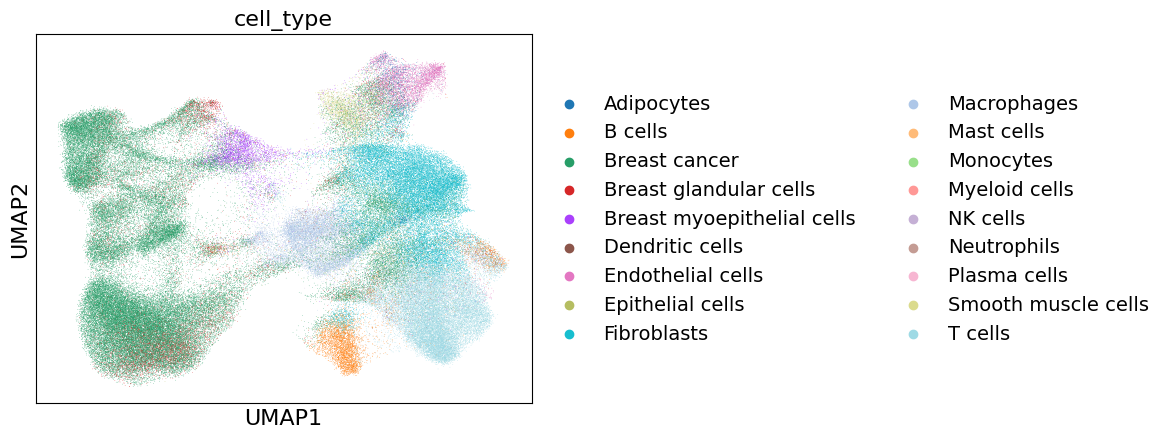

In [22]:
sc.pl.umap(xd.cells.matrix, color="cell_type")

In [23]:
xd.show()

## Visualization in napari

The cell type annotation can be selected in the "Show data" widget on the right under "observation" and then be displayed with the "Add" button:

<left><img src="./demo_screenshots/napari_cell_annotation_marked.jpg" width="1000"/></left>

When the the correct layer is selected in the layer list on the left, it is possible to hover with the mouse onto a cell and see the annotation of this cell on the bottom left under "value".



## Save results

In [24]:
xd.save()

Updating project in c:\Users\ge37voy\Github\InSituPy\notebooks\demo_dataset\demo_insitupy_project
	Updating cells...
Saved.
Reloading following modalities: cells,images
Loading cells...
	No alternative cells found...
Loading images...
`ImageData` object contains already an image with name 'nuclei'. Image is not added.
`ImageData` object contains already an image with name 'CD20'. Image is not added.
`ImageData` object contains already an image with name 'HER2'. Image is not added.
`ImageData` object contains already an image with name 'DAPI'. Image is not added.
`ImageData` object contains already an image with name 'HE'. Image is not added.
